* Comparing the stop criterion of precision is the goal with the enhanced version
* Describing the risk version

# Setup

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import beta

from utils_stats import (
    #hdi_ci_limits,
    successes_failures_to_hdi_ci_limits
)

from utils_viz import (
    #plot_success_rates
    plot_vhlines_lines,
    #plot_parity_line,
)

seed = 7

In [3]:

import matplotlib.pyplot as plt
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

FIG_WIDTH, FIG_HEIGHT = 8, 6

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = FIG_WIDTH, FIG_HEIGHT
# plt.rcParams["hatch.linewidth"] = 0.2

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Data

Experiments each containing many Bernoulli trials

In [58]:
success_rate_null = 0.5   # this is the null hypothesis, not necessarilly true
dsuccess_rate = 0.05 #success_rate * 0.1
rope_precision_fraction = 0.8

success_rate = 0.5  #0.65  #0.5 + 0.5 * dsuccess_rate  # the true value
# --------

rope_min = success_rate_null - dsuccess_rate
rope_max = success_rate_null + dsuccess_rate

# hypothesis: if precision_goal is lower, then PitG has less of
# an inconclusiveness problem but at the expense of more trials.
precision_goal = (2 * dsuccess_rate) * rope_precision_fraction
#precision_goal = (dsuccess_rate) * rope_precision_fraction # 1500 was not enough for 0.04
#precision_goal = (1.5 * dsuccess_rate) * rope_precision_fraction # 1500 was not enough for 0.04


print(f"{success_rate_null:0.5}: null")
print(f"{rope_min:0.2}: ROPE min")
print(f"{rope_max:0.2}: ROPE max")
print("-" * 20)
print(f"{precision_goal:0.2}: Precision Goal")
print("-" * 20)
print(f"{success_rate:0.3}: true")

0.5: null
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal
--------------------
0.5: true


In [59]:
experiments = 500 # number of experiments 500 #200 #300 #200
n_samples = 1500  #2500 # max number of samples in each experiement #2500 #1000 #1500

np.random.seed(seed)
samples = np.random.binomial(1, success_rate, [experiments, n_samples])

samples.shape  # (experiments, n_samples)

(500, 1500)

# Enhanced Precision is the Goal

As compared to "Precision is the Goal" and HDI+ROPE.

In [60]:
dict_successes_failures_hdi_limits = {}
dict_successes_failures_counter = {}

def _update_iteration_tally(iteration_dict, iteration):
    for this_iteration in range(iteration, len(iteration_dict)+1):
        iteration_dict[this_iteration] += 1

def booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above):
    if decision_accept:
        return "within"
    elif decision_reject_below:
        return "below"
    elif decision_reject_above:
        return "above"

def successes_failures_to_hdi_limits(successes, failures):

    pair = (successes, failures)
    if pair not in dict_successes_failures_hdi_limits:
        dict_successes_failures_hdi_limits[pair] =\
            successes_failures_caculate_hdi_limits(successes, failures)
        dict_successes_failures_counter[pair] = 1
    else:
        dict_successes_failures_counter[pair] += 1

    return dict_successes_failures_hdi_limits[pair]


def successes_failures_caculate_hdi_limits(successes, failures):
    aa = int(successes)
    bb = int(failures)
    
    if not failures:
        aa += 1
        bb += 1
        
    if not successes:
        aa += 1
        bb += 1

    hdi_min, hdi_max = successes_failures_to_hdi_ci_limits(aa, bb)

    return hdi_min, hdi_max

In [61]:
# For each method and rope result type creating tally of outcomes

method_roperesult_iteration = {}
methods = ["pitg", "epitg", "hdi_rope"]
rope_results = ["within", "below", "above"]
for method in methods:
    method_roperesult_iteration[method] = {}
    for rope_result in rope_results:
        method_roperesult_iteration[method][rope_result] = {iteration: 0 for iteration in range(1, n_samples + 1)}

print(method, rope_result)
len(method_roperesult_iteration[method][rope_result])

hdi_rope above


1500

In [62]:
iteration_number = np.arange(1, n_samples + 1)

method_stats = {"pitg": {}, "epitg": {}, "hdi_rope": {}}

for isample, sample in enumerate(samples):
    pitg_stopped = False
    hdi_rope_stopped = False

    iteration_successes = sample.cumsum()
    iteration_failures = iteration_number - iteration_successes

    for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
        final_iteration = iteration == iteration_number[-1]
        hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
        #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

        # has the precision goal been achieved?
        precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

        # is the HDI conclusively within or outside the ROPE?
        decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
        decision_reject_below = hdi_max < rope_min  
        decision_reject_above = rope_max < hdi_min
        conclusive = decision_accept | decision_reject_above | decision_reject_below

        iteration_results = {"decision_iteration": iteration,
                                                 "accept": decision_accept,
                                                    "reject_below": decision_reject_below,
                                                    "reject_above": decision_reject_above,
                                                    "conclusive": conclusive,
                                                    "inconclusive": not conclusive,
                                                    "successes": successes,
                                                    "failures": failures,
                                                    "hdi_min": hdi_min,
                                                    "hdi_max": hdi_max,
                                                 }   

        if precision_goal_achieved:

            # update Precision Is The Goal Stop
            if pitg_stopped is False:
                # not applying `break` because we continue for ePiTG
                if conclusive:
                    rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
                    _update_iteration_tally(method_roperesult_iteration["pitg"][rope_result], iteration)
                method_stats["pitg"][isample] = iteration_results
                pitg_stopped = True  # sample does not continue with PITG (only ePiTG) 

            # continue with Enhance Precision Is The Goal
            if conclusive:
                rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
                _update_iteration_tally(method_roperesult_iteration["epitg"][rope_result], iteration)

            if conclusive | final_iteration:
                method_stats["epitg"][isample] = iteration_results
                if final_iteration:
                    print(f"Sample {isample} at final iteration")
                    print(method_stats["epitg"][isample])
                break
        
        elif conclusive & (hdi_rope_stopped is False):
            # case in which precision not achieved yet but conclusive.
            # this is the HDI+ROPE approach which disregards precision
            rope_result = booleans_to_rope_result(decision_accept, decision_reject_below, decision_reject_above)
            _update_iteration_tally(method_roperesult_iteration["hdi_rope"][rope_result], iteration)
            method_stats["hdi_rope"][isample] = iteration_results

            hdi_rope_stopped = True

        elif final_iteration:
            # ensures that if reached final iteration and not conclusive that
            # results are still recorded as inconclusive
            
            """
            decision_accept = False
            decision_reject_below = False
            decision_reject_above = False
            conclusive = False
            """
            if isample not in method_stats["hdi_rope"]:
               method_stats["hdi_rope"][isample] = iteration_results
            if isample not in method_stats["pitg"]:
                method_stats["pitg"][isample] = iteration_results
            if isample not in method_stats["epitg"]:
                method_stats["epitg"][isample] = iteration_results
            break

Sample 140 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 708, 'failures': 792, 'hdi_min': 0.446766867411269, 'hdi_max': 0.4972694566161049}
Sample 165 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 809, 'failures': 691, 'hdi_min': 0.5141054692980911, 'hdi_max': 0.5645305410768443}
Sample 169 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 698, 'failures': 802, 'hdi_min': 0.4401126621762446, 'hdi_max': 0.4905728257358288}
Sample 171 at final iteration
{'decision_iteration': 1500, 'accept': False, 'reject_below': False, 'reject_above': False, 'conclusive': False, 'inconclusive': True, 'successes': 705, 'failures': 795, 'hdi_min': 0.44

In [63]:
pd.Series(dict_successes_failures_counter).value_counts(normalize=True).sort_index()

1      0.315414
2      0.142626
3      0.082128
4      0.057321
5      0.043627
         ...   
196    0.000018
197    0.000018
224    0.000018
231    0.000018
269    0.000018
Name: proportion, Length: 122, dtype: float64

In [64]:
def stats_dict_to_df(method_stats):
    df = pd.DataFrame(method_stats).T
    df.index.name = "experiment_number"
    df["precision"] = df["hdi_max"] - df["hdi_min"]
    df["success_rate"] = df["successes"] / (df["successes"] + df["failures"])
    return df


df_stats_epitg = stats_dict_to_df(method_stats["epitg"])
df_stats_epitg.head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,760,True,False,False,True,False,369,391,0.450039,0.521038,0.070999,0.485526
1,599,True,False,False,True,False,299,300,0.459174,0.539161,0.079987,0.499165
2,794,True,False,False,True,False,409,385,0.48037,0.549832,0.069462,0.515113
3,599,True,False,False,True,False,295,304,0.452509,0.532487,0.079978,0.492487


In [65]:
df_stats_pitg = stats_dict_to_df(method_stats["pitg"])
df_stats_pitg.head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,598,False,False,False,False,True,288,310,0.44161,0.521609,0.079999,0.481605
1,599,True,False,False,True,False,299,300,0.459174,0.539161,0.079987,0.499165
2,597,False,False,False,False,True,318,279,0.492653,0.572602,0.079949,0.532663
3,599,True,False,False,True,False,295,304,0.452509,0.532487,0.079978,0.492487


In [104]:
len(method_stats["hdi_rope"])

328

In [66]:
df_stats_hdirope = stats_dict_to_df(method_stats["hdi_rope"])
df_stats_hdirope.head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
0,424,True,False,False,True,False,211,213,0.45014,0.545164,0.095024,0.497642
1,443,True,False,False,True,False,223,220,0.456903,0.549872,0.092969,0.503386
3,597,True,False,False,True,False,293,304,0.450736,0.530843,0.080107,0.490787
4,445,True,False,False,True,False,224,221,0.456992,0.549753,0.092761,0.503371


In [67]:
df_stats_pitg.equals(df_stats_epitg)

False

In [68]:
def iteration_counts_to_df(roperesult_iteration, experiments):
    df = pd.DataFrame({
        "iteration": list(roperesult_iteration["within"].keys()),
        "accept": list(roperesult_iteration["within"].values()),
        "reject_below": list(roperesult_iteration["below"].values()),
        "reject_above": list(roperesult_iteration["above"].values())
    })

    df['reject'] = df['reject_above'] + df['reject_below']
    df['inconclusive'] = experiments - df['accept'] - df['reject']

    return df

df_pitg_counts = iteration_counts_to_df(method_roperesult_iteration["pitg"], experiments)
df_epitg_counts = iteration_counts_to_df(method_roperesult_iteration["epitg"], experiments)
df_hdirope_counts = iteration_counts_to_df(method_roperesult_iteration["hdi_rope"], experiments)


df_epitg_counts.head(4)

,iteration,accept,reject_below,reject_above,reject,inconclusive
0,1,0,0,0,0,500
1,2,0,0,0,0,500
2,3,0,0,0,0,500
3,4,0,0,0,0,500


In [69]:
df_epitg_counts.describe()

,iteration,accept,reject_below,reject_above,reject,inconclusive
count,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.000000
mean,750.500000,246.762667,0.0,0.0,0.0,253.237333
std,433.157015,209.758490,0.0,0.0,0.0,209.758490
min,1.000000,0.000000,0.0,0.0,0.0,13.000000
25%,375.750000,0.000000,0.0,0.0,0.0,48.000000
50%,750.500000,319.500000,0.0,0.0,0.0,180.500000
75%,1125.250000,452.000000,0.0,0.0,0.0,500.000000
max,1500.000000,487.000000,0.0,0.0,0.0,500.000000


In [70]:
df_pitg_counts.describe()

,iteration,accept,reject_below,reject_above,reject,inconclusive
count,1500.000000,1500.000000,1500.0,1500.0,1500.0,1500.000000
mean,750.500000,105.834667,0.0,0.0,0.0,394.165333
std,433.157015,86.202544,0.0,0.0,0.0,86.202544
min,1.000000,0.000000,0.0,0.0,0.0,324.000000
25%,375.750000,0.000000,0.0,0.0,0.0,324.000000
50%,750.500000,176.000000,0.0,0.0,0.0,324.000000
75%,1125.250000,176.000000,0.0,0.0,0.0,500.000000
max,1500.000000,176.000000,0.0,0.0,0.0,500.000000


In [71]:
df_pitg_counts.equals(df_epitg_counts)

False

Text(0.5, 1.0, 'true success rate = 0.500')

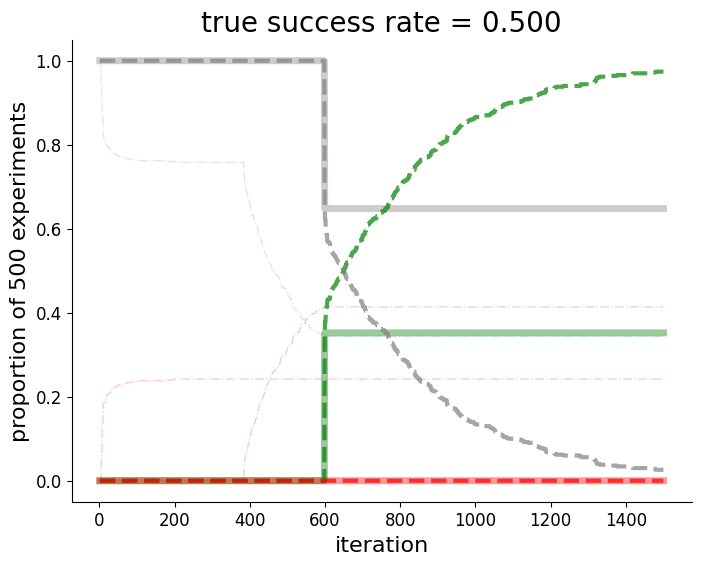

In [72]:
title = f"true success rate = {success_rate:0.3f}"
xlabel = "iteration"

iteration_values = df_pitg_counts["iteration"]

# plotting HDI+ROPE
alpha, linewidth, linestyle = 0.2, 1, "-."
plt.plot(iteration_values, df_hdirope_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_hdirope_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_hdirope_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha, linestyle=linestyle)


# plotting pitg
alpha, linewidth = 0.4, 5
plt.plot(iteration_values, df_pitg_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha)
plt.plot(iteration_values, df_pitg_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha)
plt.plot(iteration_values, df_pitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha)

# plotting epitg
alpha, linewidth, linestyle = 0.7, 3, "--"
plt.plot(iteration_values, df_epitg_counts['accept'] / experiments, color="green", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_epitg_counts['reject'] / experiments, color="red", linewidth=linewidth, alpha=alpha, linestyle=linestyle)
plt.plot(iteration_values, df_epitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth, alpha=alpha, linestyle=linestyle)


#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")
plt.title(title)

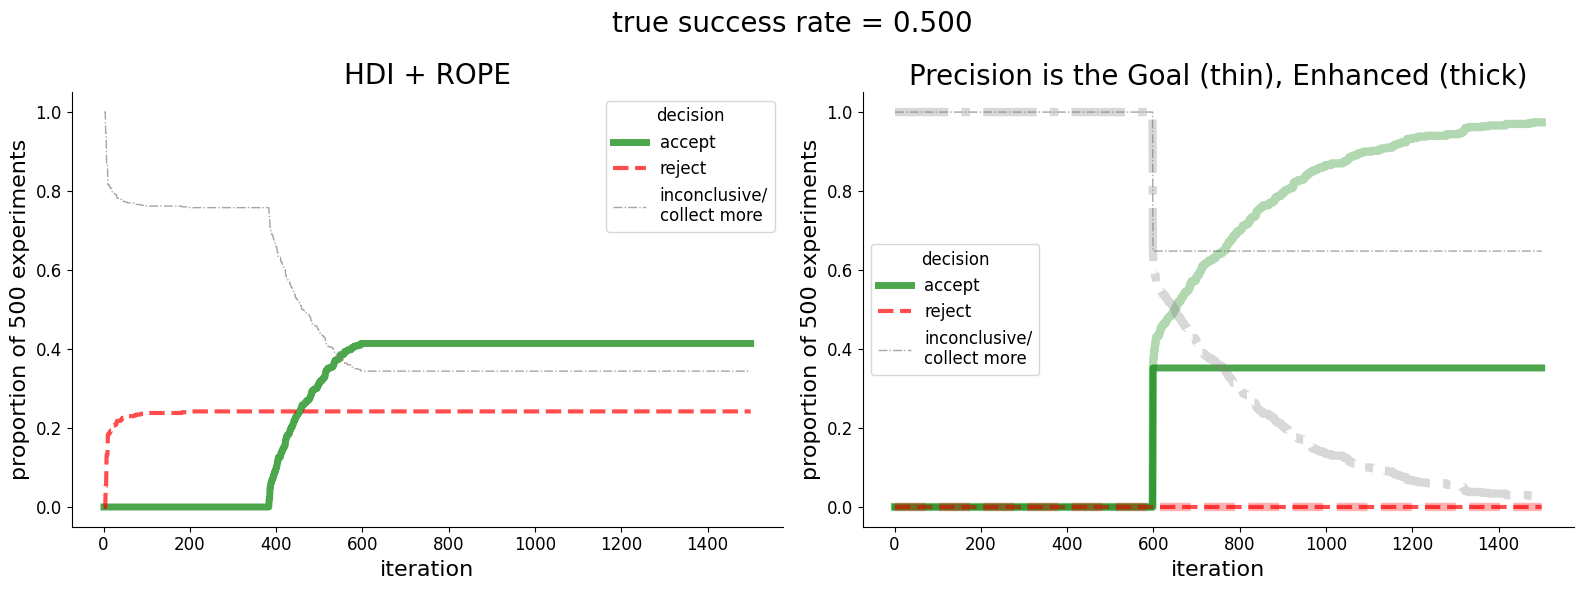

In [85]:
plt.figure(figsize=(FIG_WIDTH * 2, FIG_HEIGHT))

viz_epitg = True

suptitle = f"true success rate = {success_rate:0.3f}"
alpha=0.7

linestyle_accept, linewidth_accept = None, 5
linestyle_reject, linewidth_reject = "--", 3
linestyle_inconclusive, linewidth_inconclusive = "-.", 1


plt.subplot(1, 2, 1)

# plotting HDI+ROPE
plt.plot(iteration_values, df_hdirope_counts['accept'] / experiments, color="green", linewidth=linewidth_accept, alpha=alpha, linestyle=linestyle_accept, label="accept")
plt.plot(iteration_values, df_hdirope_counts['reject'] / experiments, color="red", linewidth=linewidth_reject, alpha=alpha, linestyle=linestyle_reject, label="reject")
plt.plot(iteration_values, df_hdirope_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_inconclusive, alpha=alpha, linestyle=linestyle_inconclusive, label="inconclusive/\ncollect more")

plt.legend(title="decision")
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")
plt.title("HDI + ROPE")


plt.subplot(1, 2, 2)

# plotting PitG
plt.plot(iteration_values, df_pitg_counts['accept'] / experiments, color="green", linewidth=linewidth_accept, alpha=alpha, linestyle=linestyle_accept, label="accept")
plt.plot(iteration_values, df_pitg_counts['reject'] / experiments, color="red", linewidth=linewidth_reject, alpha=alpha, linestyle=linestyle_reject, label="reject")
plt.plot(iteration_values, df_pitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_inconclusive, alpha=alpha, linestyle=linestyle_inconclusive, label="inconclusive/\ncollect more")

if viz_epitg:
    linewidth_epitg, alpha_epitg = 6, 0.3
    plt.plot(iteration_values, df_epitg_counts['accept'] / experiments, color="green", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_accept, label=None)
    plt.plot(iteration_values, df_epitg_counts['reject'] / experiments, color="red", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_reject, label=None)
    plt.plot(iteration_values, df_epitg_counts['inconclusive'] / experiments, color="gray", linewidth=linewidth_epitg, alpha=alpha_epitg, linestyle=linestyle_inconclusive, label=None)
    plt.title("Precision is the Goal (thin), Enhanced (thick)")
else:
    plt.title("Precision is the Goal")


plt.legend(title="decision")
plt.xlabel(xlabel)
plt.ylabel(f"proportion of {experiments:,} experiments")


plt.suptitle(suptitle, fontsize=20)
plt.tight_layout()

In [77]:
df_hdirope_counts[""]

,iteration,accept,reject_below,reject_above,reject,inconclusive
0,1,0,0,0,0,500
1,2,0,0,0,0,500
2,3,0,0,0,0,500
3,4,0,0,0,0,500
4,5,0,14,13,27,473
...,...,...,...,...,...,...
1495,1496,207,62,59,121,172
1496,1497,207,62,59,121,172
1497,1498,207,62,59,121,172
1498,1499,207,62,59,121,172


In [83]:
(207)/500.

0.414

In [80]:
207./1500

0.138

In [81]:
experiments

500

In [105]:
import seaborn as sns

# df_stats_hdirope["decision_iteration"], df_stats_hdirope["success_rate"]

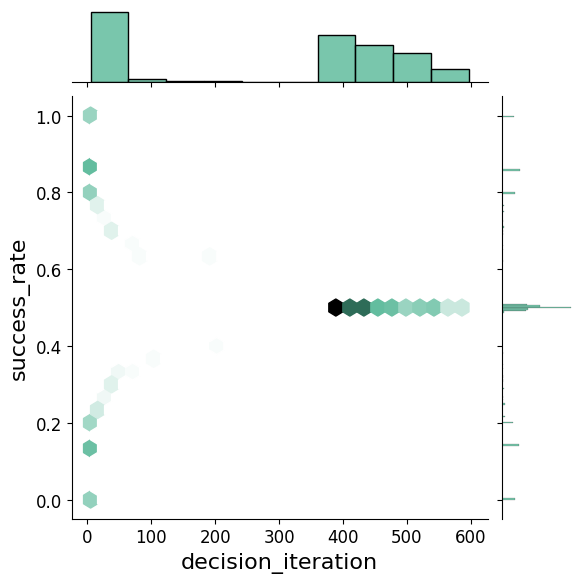

In [107]:
sns.jointplot(x=df_stats_hdirope["decision_iteration"], y=df_stats_hdirope["success_rate"], kind="hex", color="#4CB391")

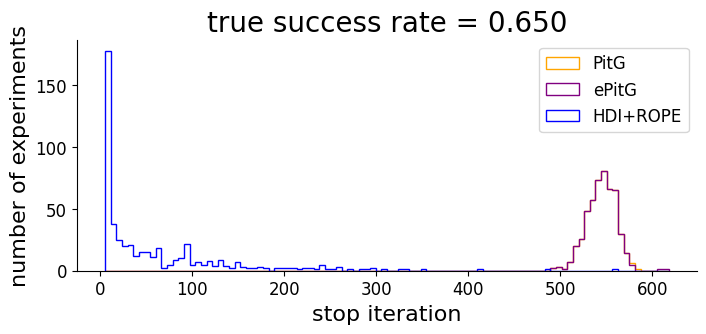

In [19]:
plt.figure(figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT))

all_values = np.concatenate([df_stats_epitg["decision_iteration"], df_stats_pitg["decision_iteration"], df_stats_hdirope["decision_iteration"] ])

_, bins = np.histogram(all_values, bins=100)

plt.hist(df_stats_pitg["decision_iteration"], bins=bins, histtype='step', label="PitG", color="orange")
plt.hist(df_stats_epitg["decision_iteration"], bins=bins, histtype='step', label="ePitG", color="purple")   
plt.hist(df_stats_hdirope["decision_iteration"], bins=bins, histtype='step', label="HDI+ROPE", color="blue")   
plt.xlabel("stop iteration")
plt.ylabel("number of experiments")
plt.legend()
plt.title(title)
pass

In [20]:
# TODO: rope_min, rope_max are not defined
def plot_pdf(sr_experiment_stats, xlim=None):
    pp = np.linspace(0, 1, 1000)
    pp_hdi = np.linspace(sr_experiment_stats["hdi_min"], sr_experiment_stats["hdi_max"], 1000)

    successes = sr_experiment_stats["successes"]
    failures = sr_experiment_stats["failures"]
    rate = successes / (successes + failures)
    n_ = successes + failures

    pdf = beta.pdf(pp, successes, failures)
    pdf_hdi = beta.pdf(pp_hdi, successes, failures)

    plt.plot(pp, pdf, color="purple", label=f"pdf p={rate:0.2f}; n={n_:,}")
    plt.fill_between(pp_hdi, pdf_hdi, color="purple", alpha=0.2, label="HDI")
    plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
    plot_vhlines_lines(vertical=rope_max, horizontal=None)
    plt.legend()
    plt.xlabel("success rate")
    plt.ylabel("probability density")

    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim([rope_min - 0.1, rope_max + 0.1])

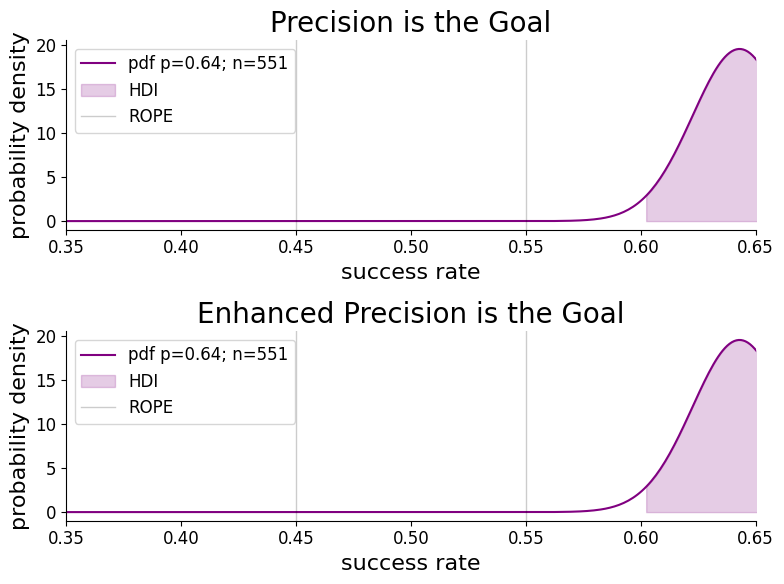

In [21]:
# experiment with the latest iteration
#idx = df_stats_epitg["decision_iteration"].astype(float).argmax()


# pitg inconclusive
#idx = df_stats_pitg.query("inconclusive").index[0]
idx = df_stats_pitg.index[0]

# ---
sr_experiment_stats_pitg = df_stats_pitg.loc[idx]
sr_experiment_stats_epitg = df_stats_epitg.loc[idx]

fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.subplot(2, 1, 1)
plot_pdf(sr_experiment_stats_pitg) #, xlim=(0.4,1))
plt.title("Precision is the Goal")

plt.subplot(2, 1, 2)
plt.title("Enhanced Precision is the Goal")
plot_pdf(sr_experiment_stats_epitg) #, xlim=(0.4,1))
plt.tight_layout()

In [22]:
df_stats_pitg.astype(float).describe()

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
count,500.000000,500.0,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,544.168000,0.0,0.0,0.994000,0.994000,0.006000,353.466000,190.702000,0.609999,0.689943,0.079943,0.650128
std,15.107888,0.0,0.0,0.077304,0.077304,0.077304,2.143369,16.578144,0.020828,0.020825,0.000028,0.020853
min,493.000000,0.0,0.0,0.000000,0.000000,0.000000,341.000000,143.000000,0.545869,0.625801,0.079887,0.585911
25%,534.000000,0.0,0.0,1.000000,1.000000,0.000000,353.000000,179.000000,0.595927,0.675868,0.079923,0.636036
50%,545.000000,0.0,0.0,1.000000,1.000000,0.000000,354.000000,190.000000,0.611270,0.691163,0.079943,0.651376
75%,555.000000,0.0,0.0,1.000000,1.000000,0.000000,355.000000,202.000000,0.624643,0.704591,0.079962,0.664794
max,582.000000,0.0,0.0,1.000000,1.000000,1.000000,355.000000,241.000000,0.669725,0.749681,0.079998,0.709939


Text(0.5, 0, 'success rate at stop')

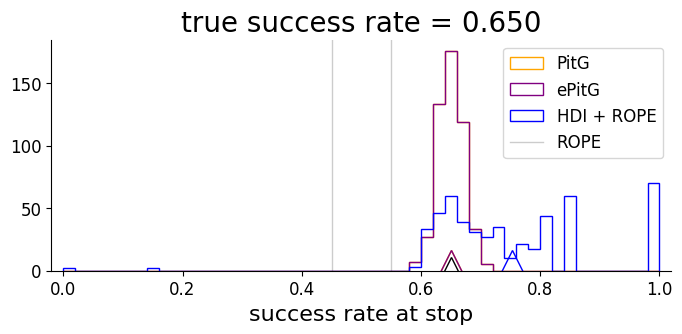

In [23]:
plt.figure(figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT))

all_values = np.concatenate([df_stats_epitg["success_rate"], df_stats_pitg["success_rate"], df_stats_hdirope["success_rate"]])
_, bins = np.histogram(all_values, bins=50)

plt.hist(df_stats_pitg["success_rate"], bins=bins, histtype='step', label="PitG", color="orange")
plt.hist(df_stats_epitg["success_rate"], bins=bins, histtype='step', label="ePitG", color="purple")
plt.hist(df_stats_hdirope["success_rate"], bins=bins, histtype='step', label="HDI + ROPE", color="blue")


# marker of truth
marker_style = dict(color='black', linestyle=':', marker='^',
                    markersize=20, markerfacecoloralt='tab:black')
plt.plot([success_rate], [0], fillstyle='none' , **marker_style)

plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
plot_vhlines_lines(vertical=rope_max, horizontal=None)

# marker of pitg
marker_style = dict(color='orange', linestyle='--', marker='^',
                    markersize=30, markerfacecoloralt='tab:orange')
plt.plot([df_stats_pitg["success_rate"].mean()], [0], **marker_style, fillstyle='none')

# marker of epitg
marker_style = dict(color='purple', linestyle=':', marker='^',
                   markersize=30, markerfacecoloralt='tab:purple')
plt.plot([df_stats_epitg["success_rate"].mean()], [0], **marker_style, fillstyle='none')

# marker of hdi+rope
marker_style = dict(color='blue', linestyle=':', marker='^',
                    markersize=30, markerfacecoloralt='tab:blue')
plt.plot([df_stats_hdirope["success_rate"].mean()], [0], **marker_style, fillstyle='none')

plt.legend()

xlim = [np.min([rope_min, all_values.min()]), np.max([rope_max, all_values.max()])]
plt.xlim([xlim[0] - 0.02, xlim[1] + 0.02])
plt.title(title)
plt.xlabel("success rate at stop")

Text(0.5, 1.0, 'true success rate = 0.500')

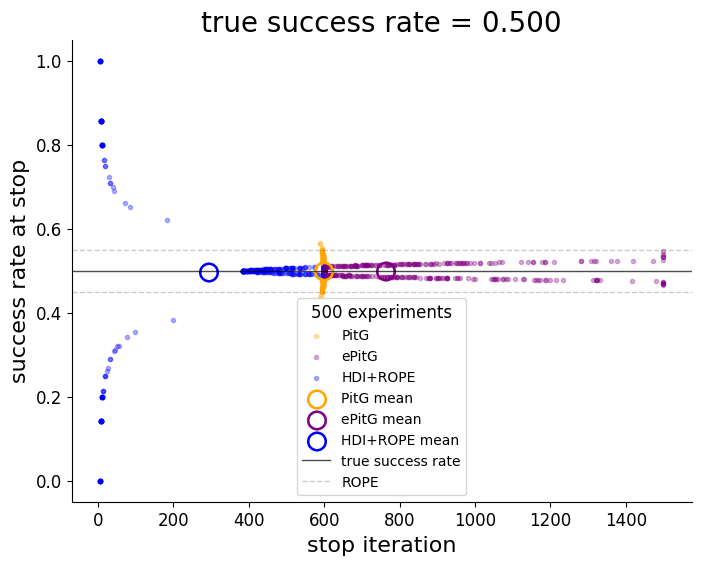

In [92]:
plt.scatter(df_stats_pitg["decision_iteration"], df_stats_pitg["success_rate"], alpha=0.3, color="orange", label="PitG", marker=".")
plt.scatter(df_stats_epitg["decision_iteration"], df_stats_epitg["success_rate"], alpha=0.3, color="purple", label="ePitG", marker=".")
plt.scatter(df_stats_hdirope["decision_iteration"], df_stats_hdirope["success_rate"], alpha=0.3, color="blue", label="HDI+ROPE", marker=".")


plt.scatter(df_stats_pitg["decision_iteration"].mean(), df_stats_pitg["success_rate"].mean(), color="orange", label="PitG mean", s=200, marker="$\u25EF$")
plt.scatter(df_stats_epitg["decision_iteration"].mean(), df_stats_epitg["success_rate"].mean(), color="purple", label="ePitG mean", s=200, marker="$\u25EF$")
plt.scatter(df_stats_hdirope["decision_iteration"].mean(), df_stats_hdirope["success_rate"].mean(), color="blue", label="HDI+ROPE mean", s=200, marker="$\u25EF$")


plot_vhlines_lines(vertical=None, label='true success rate', horizontal=success_rate, alpha=0.7)

plot_vhlines_lines(vertical=None, label='ROPE', horizontal=rope_min, linestyle="--")
plot_vhlines_lines(vertical=None, horizontal=rope_max, linestyle="--")
plt.xlabel("stop iteration")
plt.ylabel("success rate at stop")

plt.legend(title=f"{len(df_stats_pitg):,} experiments", loc="lower center", fontsize=10)
plt.title(title)

In [100]:
df_stats_hdirope.query("decision_iteration < 200").shape[0]/experiments

0.242

In [101]:
df_stats_hdirope.shape

(328, 12)

In [102]:
df_stats_epitg.shape

(500, 12)

In [103]:
df_stats_pitg.shape

(500, 12)

In [25]:
(df_stats_hdirope.query("conclusive")["reject_below"] + df_stats_hdirope.query("conclusive")["reject_above"]).astype(float).sum() / len(df_stats_hdirope.query("conclusive"))

1.0

In [26]:
df_stats_hdirope.query(f"hdi_min > {success_rate-0.1}").sort_values("hdi_min")

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
143,485,False,False,True,True,False,288,197,0.55006,0.63734,0.087281,0.593814
368,242,False,False,True,True,False,148,94,0.550097,0.672518,0.122421,0.61157
314,242,False,False,True,True,False,148,94,0.550097,0.672518,0.122421,0.61157
309,242,False,False,True,True,False,148,94,0.550097,0.672518,0.122421,0.61157
467,273,False,False,True,True,False,166,107,0.55011,0.665602,0.115492,0.608059
...,...,...,...,...,...,...,...,...,...,...,...,...
50,7,False,False,True,True,False,6,1,0.606962,1.0,0.393038,0.857143
359,7,False,False,True,True,False,6,1,0.606962,1.0,0.393038,0.857143
49,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0


In [28]:
df_stats_hdirope["stop_success_rate"] = df_stats_hdirope["successes"] / df_stats_hdirope["decision_iteration"]

In [30]:
df_stats_hdirope.sort_values("stop_success_rate", ascending=False).head(20)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate,stop_success_rate
experiment_number,,,,,,,,,,,,,
353,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0
237,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0
65,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0
243,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0
130,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0
133,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0
58,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0
464,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0
316,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0,1.0


In [26]:
df_stats_hdirope.query("reject_above").head(20)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
8,7,False,False,True,True,False,6,1,0.606962,1.0,0.393038,0.857143
9,7,False,False,True,True,False,6,1,0.606962,1.0,0.393038,0.857143
13,29,False,False,True,True,False,21,8,0.562987,0.876762,0.313775,0.724138
14,10,False,False,True,True,False,8,2,0.56655,0.991365,0.424815,0.8
44,10,False,False,True,True,False,8,2,0.56655,0.991365,0.424815,0.8
54,7,False,False,True,True,False,6,1,0.606962,1.0,0.393038,0.857143
78,7,False,False,True,True,False,6,1,0.606962,1.0,0.393038,0.857143
84,5,False,False,True,True,False,5,0,0.606962,1.0,0.393038,1.0
86,7,False,False,True,True,False,6,1,0.606962,1.0,0.393038,0.857143


In [27]:
df_stats_epitg.sort_values("decision_iteration", ascending=False)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,precision,success_rate
experiment_number,,,,,,,,,,,,
250,1500,False,False,False,False,True,701,799,0.442112,0.492586,0.050474,0.467333
349,1500,False,False,False,False,True,820,680,0.521462,0.571823,0.050361,0.546667
241,1500,False,False,False,False,True,798,702,0.506746,0.557224,0.050478,0.532
265,1500,False,False,False,False,True,802,698,0.509427,0.559887,0.05046,0.534667
307,1500,False,False,False,False,True,706,794,0.445422,0.495917,0.050495,0.470667
...,...,...,...,...,...,...,...,...,...,...,...,...
260,599,True,False,False,True,False,302,297,0.464182,0.544166,0.079984,0.504174
114,599,True,False,False,True,False,301,298,0.462503,0.542489,0.079986,0.502504
59,599,True,False,False,True,False,305,294,0.469193,0.549167,0.079973,0.509182


In [49]:
df_stats_pitg["inconclusive"].value_counts()/ len(df_stats_pitg)

inconclusive
True     0.648
False    0.352
Name: count, dtype: float64

In [50]:
df_stats_epitg["inconclusive"].value_counts()/ len(df_stats_pitg)

inconclusive
False    0.974
True     0.026
Name: count, dtype: float64

In [86]:
isample = 179 #8 # found via df_stats_hdirope.query("reject_above").head(20)
#isample = 250 # found via df_stats_epitg.sort_values("decision_iteration", ascending=False)
#isample = 353

sample = samples[isample]
iteration_successes = sample.cumsum()
iteration_failures = iteration_number - iteration_successes

sample_results = {}
for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
    final_iteration = iteration == iteration_number[-1]
    hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
    #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

    # has the precision goal been achieved?
    precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

    # is the HDI conclusively within or outside the ROPE?
    decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
    decision_reject_below = hdi_max < rope_min  
    decision_reject_above = rope_max < hdi_min
    conclusive = decision_accept | decision_reject_above | decision_reject_below


    iteration_results = {"decision_iteration": iteration,
                                                "accept": decision_accept,
                                                "reject_below": decision_reject_below,
                                                "reject_above": decision_reject_above,
                                                "conclusive": conclusive,
                                                "inconclusive": not conclusive,
                                                "successes": successes,
                                                "failures": failures,
                                                "hdi_min": hdi_min,
                                                "hdi_max": hdi_max,
                                                "goal_achieved": precision_goal_achieved,
                                                }   

    sample_results[iteration] = iteration_results

In [87]:
df_sample_results = pd.DataFrame(sample_results).T
df_sample_results["hdi_max"] = df_sample_results["hdi_max"].astype(float)
df_sample_results["hdi_min"] = df_sample_results["hdi_min"].astype(float)
df_sample_results["decision_iteration"] = df_sample_results["decision_iteration"].astype(float)

df_sample_conclusive = df_sample_results.query("conclusive")
display(df_sample_conclusive.head(4))

df_sample_goal = df_sample_results.query("goal_achieved")
display(df_sample_goal.head(4))

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,goal_achieved
86,86.0,False,False,True,True,False,56,30,0.550444,0.749943,False
89,89.0,False,False,True,True,False,58,31,0.552679,0.748781,False
90,90.0,False,False,True,True,False,59,31,0.557350,0.751853,False
91,91.0,False,False,True,True,False,60,31,0.561911,0.754836,False


,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,goal_achieved
597,597.0,False,False,False,False,True,315,282,0.487620,0.567617,True
598,598.0,False,False,False,False,True,315,283,0.486756,0.566695,True
599,599.0,False,False,False,False,True,315,284,0.485909,0.565789,True
600,600.0,False,False,False,False,True,316,284,0.486734,0.566540,True


In [88]:
df_sample_goal.query("conclusive").head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,successes,failures,hdi_min,hdi_max,goal_achieved
852,852.0,True,False,False,True,False,440,412,0.482891,0.549946,True
858,858.0,True,False,False,True,False,443,415,0.482893,0.549714,True
859,859.0,True,False,False,True,False,443,416,0.482312,0.549096,True
860,860.0,True,False,False,True,False,444,416,0.482894,0.549638,True


In [89]:
440./852

0.5164319248826291

Text(0.5, 1.0, 'true success rate = 0.500')

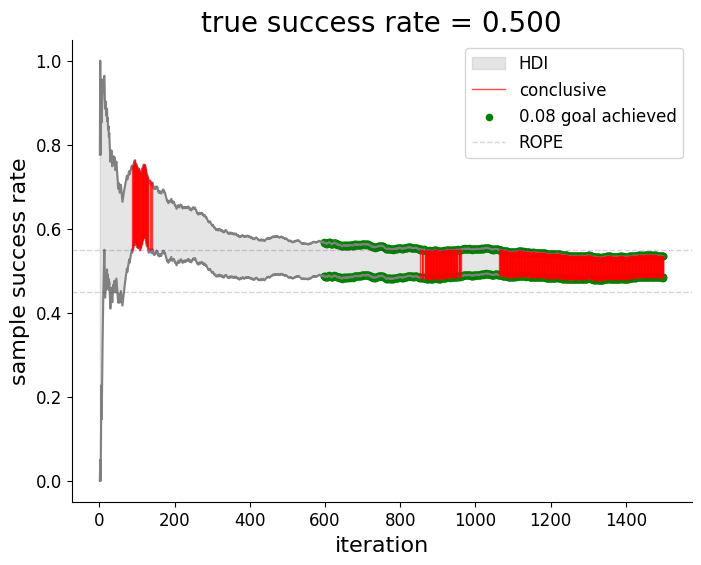

In [90]:
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.plot(df_sample_results["decision_iteration"], df_sample_results["hdi_min"], color="gray", label=None)
plt.plot(df_sample_results["decision_iteration"], df_sample_results["hdi_max"], color="gray", label=None)
plt.fill_between(df_sample_results["decision_iteration"], df_sample_results["hdi_max"], df_sample_results["hdi_min"], color='gray', alpha=0.2, label="HDI")

for idx, (iteration, row) in enumerate(df_sample_conclusive.iterrows()):
    if idx == 0:
        label = "conclusive"
    else:
        label = None
    plt.plot([iteration, iteration], [row['hdi_min'], row['hdi_max']], color='red', alpha=0.7, linewidth=1, label=label)

#for iteration, row in df_sample_goal.iterrows():
#    plt.plot([iteration, iteration], [row['hdi_min'], row['hdi_max']], color='blue', alpha=0.1, linewidth=1)
plt.scatter(df_sample_goal["decision_iteration"], df_sample_goal["hdi_min"], color="green", label=f"{precision_goal:0.3} goal achieved", marker="o", s=20)
plt.scatter(df_sample_goal["decision_iteration"], df_sample_goal["hdi_max"], color="green", label=None, marker="o", s=20)

plot_vhlines_lines(vertical=None, label='ROPE', horizontal=rope_min, linestyle="--", color="purple")
plot_vhlines_lines(vertical=None, horizontal=rope_max, linestyle="--", color="purple")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("sample success rate")
plt.title(f"true success rate = {success_rate:0.3f}")

In [ ]:
"""
    iteration_successes = sample.cumsum()
    iteration_failures = iteration_number - iteration_successes

    for iteration, successes, failures in zip(iteration_number, iteration_successes, iteration_failures):
        final_iteration = iteration == iteration_number[-1]
        hdi_min, hdi_max = successes_failures_to_hdi_limits(successes, failures)
        #hdi_min, hdi_max = successes_failures_caculate_hdi_limits(successes, failures)

        # has the precision goal been achieved?
        precision_goal_achieved = (hdi_max - hdi_min) < precision_goal

        # is the HDI conclusively within or outside the ROPE?
        decision_accept = (hdi_min >= rope_min) & (hdi_max <= rope_max)
        decision_reject_below = hdi_max < rope_min  
        decision_reject_above = rope_max < hdi_min
        conclusive = decision_accept | decision_reject_above | decision_reject_below
"""

In [91]:
(df_stats_hdirope["reject_above"] | df_stats_hdirope["reject_below"]).sum() / len(df_stats_hdirope)

0.36890243902439024

In [ ]:
(df_stats_pitg["reject_above"] | df_stats_pitg["reject_below"]).sum() / len(df_stats_pitg)

In [ ]:
(df_stats_epitg["reject_above"] | df_stats_epitg["reject_below"]).sum() / len(df_stats_epitg)

In [ ]:
df_stats_pitg["decision_iteration"].min(), df_stats_pitg["decision_iteration"].max()

In [ ]:
df_stats_pitg["inconclusive"].value_counts(normalize=True, dropna=False)  

In [ ]:
df_stats_epitg["inconclusive"].value_counts(normalize=True, dropna=False)  

In [ ]:
df_stats_pitg["success_rate"].mean(), df_stats_pitg["success_rate"].std()

In [ ]:
df_stats_epitg["success_rate"].mean(), df_stats_epitg["success_rate"].std()

In [ ]:
variances = []
hdi_widths = []
ns_ = []

for a_, b_ in dict_successes_failures_hdi_limits.keys():
    if a_ >= 10 and b_ >= 10:
        variances.append(beta.var(a_, b_))
        hdi_min, hdi_max = dict_successes_failures_hdi_limits[(a_, b_)]
        hdi_widths.append(hdi_max - hdi_min)
        ns_.append(a_ + b_)

In [ ]:
variances = np.array(variances)
hdi_widths = np.array(hdi_widths)
ns_ = np.array(ns_)

In [ ]:
plt.plot(variances, hdi_widths, marker="o", linestyle="none")

In [ ]:
plt.scatter(hdi_widths, hdi_widths/variances)

In [ ]:
plt.scatter(ns_, variances)
plt.scatter(ns_, hdi_widths)

# Precision and Risk as Goals

In [ ]:
idx = df_stats_pitg.index[0]

# ---
sr_experiment_stats_pitg = df_stats_pitg.loc[idx]
sr_experiment_stats_epitg = df_stats_epitg.loc[idx]

fig, axs = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT))

plt.subplot(2, 1, 1)
plot_pdf(sr_experiment_stats_pitg) #, xlim=(0.4,1))
plt.title("Precision is the Goal")

plt.subplot(2, 1, 2)
plt.title("Enhanced Precision is the Goal")
plot_pdf(sr_experiment_stats_epitg) #, xlim=(0.4,1))
plt.tight_layout()

In [ ]:
sr_experiment_stats_pitg

In [ ]:
def pdf_area(pdf, dpp):
    return np.sum(pdf) * dpp

sr_experiment_stats = sr_experiment_stats_pitg.copy()

dpp = 0.0001
npp = int(1./dpp)
pp = np.linspace(0., 1., npp)

successes = sr_experiment_stats["successes"]
failures = sr_experiment_stats["failures"]
#rate = successes / (successes + failures)
#n_ = successes + failures

bool_in_rope = (rope_min <= pp) & (pp <= rope_max)
p_in_rope = pdf_area(pdf[bool_in_rope], dpp)

pdf = beta.pdf(pp, successes, failures)

plt.plot(pp,pdf, color="purple")
plt.fill_between(pp, pdf, where=bool_in_rope, alpha=0.2, color="orange")
plot_vhlines_lines(vertical=rope_min, label='ROPE', horizontal=None)
plot_vhlines_lines(vertical=rope_max, horizontal=None)

plt.xlim([rope_min - 0.1, rope_max + 0.1])

    

In [ ]:
pdf_area(pdf, dpp)

In [ ]:
df_stats_pitg.head(2)

In [ ]:
df_stats_pitg["in_rope"] = df_stats_pitg.apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"])[bool_in_rope], dpp) , axis=1)

In [ ]:
df_stats_epitg["in_rope"] = df_stats_epitg.apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"])[bool_in_rope], dpp) , axis=1)

In [ ]:
df_stats_pitg["in_rope"].describe()

In [ ]:
df_stats_pitg.query("inconclusive").shape

In [ ]:
(df_pitg_plot["in_rope"] > 1- fpr).sum() / len(df_pitg_plot)

In [ ]:
fpr = 0.05

df_pitg_plot = df_stats_pitg.query("inconclusive")

df_epitg_plot = df_stats_epitg.loc[df_pitg_plot.index]

plt.scatter(df_pitg_plot["decision_iteration"], df_pitg_plot["in_rope"], alpha=0.5, color="orange", label="PitG", marker=".")
#plt.scatter(df_epitg_plot["decision_iteration"], df_epitg_plot["in_rope"], alpha=0.5, color="purple", label="ePitG", marker=".")
plt.xlabel("stop iteration")
plt.ylabel("probability in ROPE")
plot_vhlines_lines(vertical=None, label=None, horizontal=1. - fpr, alpha=0.7, linestyle="--")

In [ ]:
plt.scatter(df_pitg_plot["decision_iteration"], df_epitg_plot["decision_iteration"], alpha=0.5, color="orange", label="PitG", marker=".")

frac_ = len(df_pitg_plot) / len(df_stats_pitg)
plt.title(f"{len(df_pitg_plot):,} inconclusive experiments ({frac_:0.1%})")
plot_vhlines_lines(vertical=None, label=None, horizontal=df_pitg_plot["decision_iteration"].min(), alpha=0.7, linestyle="--")
plot_vhlines_lines(vertical=None, label=None, horizontal=df_pitg_plot["decision_iteration"].max(), alpha=0.7, linestyle="--")

In [ ]:
def plot_parity_line(ax=None):
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [np.min([xlims[0], ylims[0]]), np.max([xlims[1], ylims[1]])]

    ax.plot(lims, lims, "k--", linewidth=1)

In [ ]:
plt.scatter(df_stats_pitg["decision_iteration"], df_stats_pitg["in_rope"], alpha=0.05, color="orange", label="PitG", marker=".")
plt.scatter(df_stats_epitg["decision_iteration"], df_stats_epitg["in_rope"], alpha=0.05, color="purple", label="ePitG", marker=".")
plt.xlabel("stop iteration")
plt.ylabel("probability in ROPE")

In [ ]:
plt.hist(df_stats_pitg["in_rope"])
plt.hist(df_stats_epitg["in_rope"])

In [ ]:
df_stats_pitg.head(4).apply(lambda x: pdf_area(beta.pdf(pp, x["successes"], x["failures"]), dpp))

In [ ]:
pdf.sum() *dpp

In [ ]:
pdf